# Kalman Filter and Gaussian Processes Equivalents

This tutorial is geared towards Kalman filter experts, the goal is to draw a link between the vocabulary and model formulations used in Kalman filtering and those used in Gaussian processes. To do so we'll setup a simple 1D toy problem and demonstrate how a GP formulation can be turned into a KF and vice versa.

In [1]:
import os
import sys
import scipy
import sklearn

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tutorial_utils import *

# 1D Toy Problem

To start let's build a random time series. To keep the example as simple as possible, let's assume that what we're trying to model is a random walk (technically an [Ornstein Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process), so random walk with friction). We can use an exponential covariance to build a Gaussian process for the timeseries, and can then draw a random sample from the process,

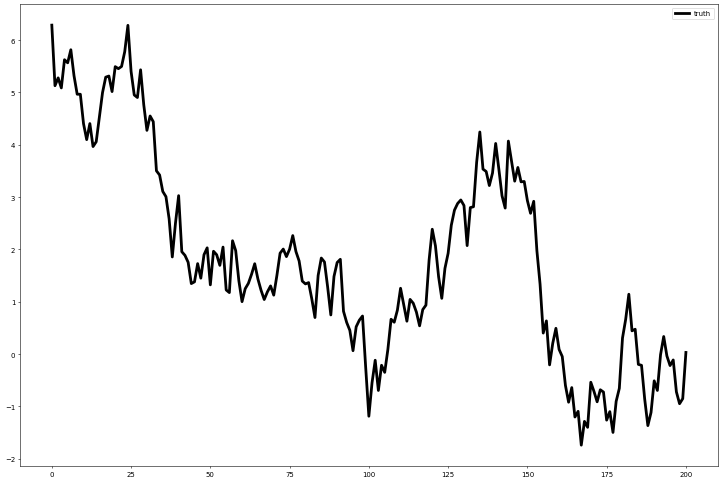

In [2]:
np.random.seed(2012)

SIGMA = 10.0
ELL = 1000.0
MEAS_NOISE_SIGMA = 0.5

x_max = 200
X_grid = np.linspace(0., x_max, x_max+1)[:, None]

def example_cov_func(x_i, x_j):
    return example_exponential(x_i, x_j, sigma=SIGMA, ell=ELL)

cov_matrix = example_cov_func(X_grid, X_grid)
truth = np.random.multivariate_normal(np.zeros(X_grid.shape[0]), cov_matrix)

def plot_truth():
    plt.plot(X_grid, truth, color="black", lw=4, label="truth")
    
plot_truth()
plt.legend()

This will be our simulated truth. Now let's assume we've taken random measurements, $y$, of the truth at regular intervals and these measurements have been contaminated by measurement noise,
$$
y \sim \mbox{truth} + \mathcal{N}\left(0, \sigma_{\epsilon}^2\right)
$$

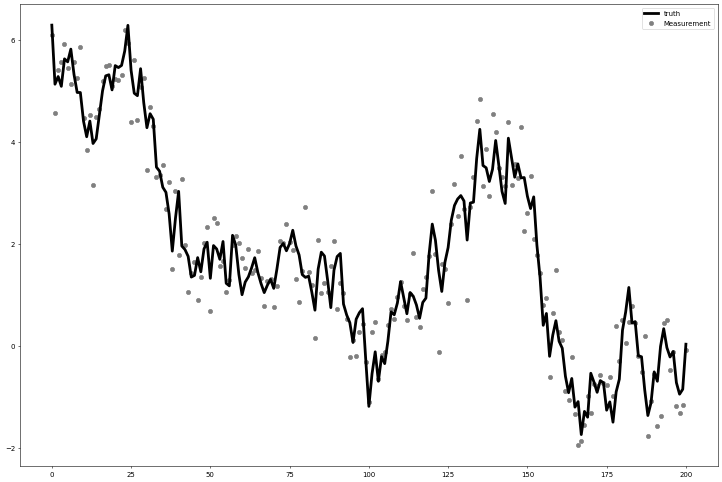

In [3]:
X = X_grid
y = truth + MEAS_NOISE_SIGMA * np.random.normal(size=X.size)

def plot_measurements():
    plt.scatter(X, y, color="grey", label="Measurement")
    
plot_truth()
plot_measurements()
plt.legend()

Now let's try to estimate the true process. We generated the truth using a GP, so we know the true covariance function and hyper parameters. We can reuse those known parameters and see what the resulting fit is. Here is a Gaussian process' posterior estimate of the true process given all the measurements,

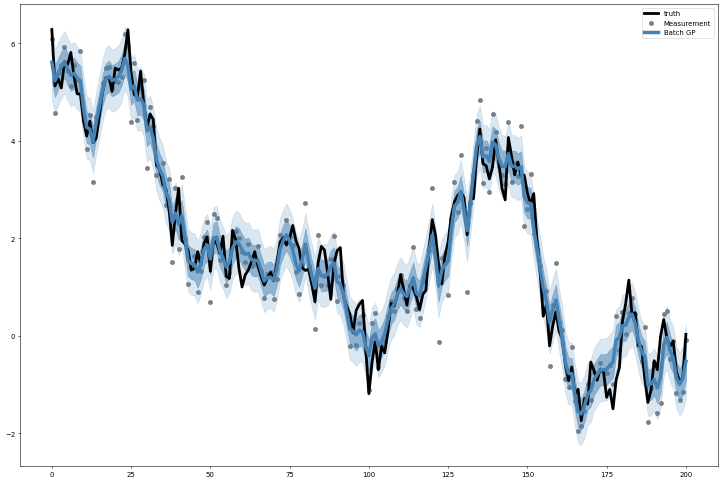

In [4]:
batch_mean, batch_variance = example_fit_and_predict(example_cov_func, X, y,
                                                     X_grid, meas_noise=MEAS_NOISE_SIGMA)
plot_truth()
plot_measurements()
plot_spread(X_grid, batch_mean, np.diag(batch_variance), label="Batch GP")
plt.legend()

Not bad, but we just fit a model to data which was drawn from the same model, so it isn't surprising the fit is good.

Let's now assume that this is a real-time task. In other words, let's treat the x-axis as time. At each time step , $t_i$ we are presented with a new measurement, $y_i$ and would like to make a prediction of the current truth, $f_i$. The key difference here is that above, we used all observations to predict all times in one big batch process, but in a real-time scenario we would not have all the observations available, so we just use everything up to the curren time to make predictions of the truth at the curren time. Then move on to the next time step and repeat,

In [5]:
def real_time_gp(cov, X, y):
    for i in range(X.shape[0]):
        # at each time t_i, we can use all the observations up to the current time.
        # to predict the i^th state.
        available_X = X[:i+1]
        available_y = y[:i+1]
        m, S = example_fit_and_predict(cov, available_X, available_y,
                                       X[i, :], meas_noise=MEAS_NOISE_SIGMA)
        yield m[0], S[0, 0]

def concatenate_mean_and_variance(estimates):
    xs, Ps = map(np.array, zip(*estimates))
    return xs, Ps

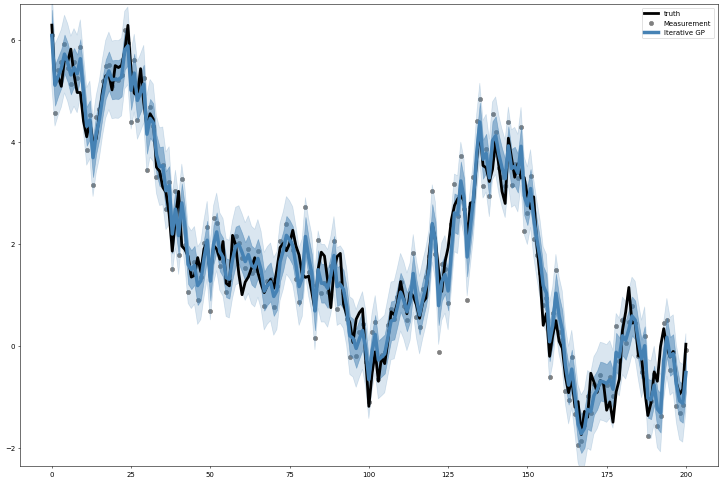

In [6]:
iterative_mean, iterative_variance = concatenate_mean_and_variance(real_time_gp(example_cov_func, X, y))

plot_truth()
plot_measurements()
ylim = plt.ylim()
plot_spread(X, iterative_mean, iterative_variance, label="Iterative GP")
plt.ylim(ylim)
plt.legend()

This interactive plot might illustrate the process best. You can adjust the time step (i) to see what a real time model would have predicted up to that point in time (red) and what it's predictions of the future are (blue)

In [7]:
from ipywidgets import interact

def plot_fit_and_predict(i, cov, X, y):
    X_train = X[:(i+1)]
    y_train = y[:(i+1)]
    iterative_mean, iterative_variance = concatenate_mean_and_variance(real_time_gp(cov, X_train, y_train))

    X_test = X[i:, :]
    pred_mean, pred_cov = example_fit_and_predict(cov, X_train, y_train,
                                                  X_test, meas_noise=MEAS_NOISE_SIGMA)
    
    plot_spread(X_train, iterative_mean, iterative_variance, color='firebrick', label="Previous Prediction")
    plot_spread(X_test, pred_mean, np.diag(pred_cov), label="Forward Prediction")
    plot_truth()
    plot_measurements()

    ylim = [-2, 6]
    plt.plot([i, i], ylim, ls=":", color="firebrick")
    plt.ylim(ylim)
    plt.legend()
    
@interact
def interactive_plot_fit_and_predict(i=(0, X.shape[0])):
    plot_fit_and_predict(i, example_cov_func, X, y)

interactive(children=(IntSlider(value=100, description='i', max=201), Output()), _dom_classes=('widget-interac…

Compare these resulting real time predictions to the batch predictions and we can see the two are similar ... but not exactly the same,

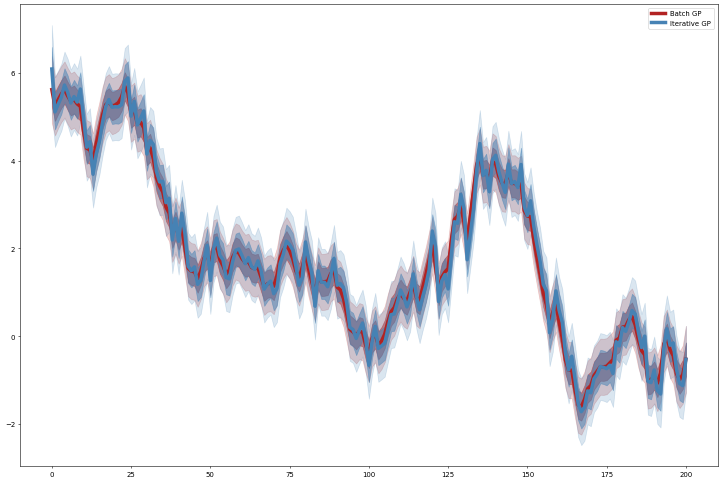

In [8]:
plot_spread(X_grid, batch_mean, np.diag(batch_variance), color="firebrick", label="Batch GP")
plot_spread(X, iterative_mean, iterative_variance, label="Iterative GP")
plt.legend()

Also notice that this "real-time" approach would not actually be feasible in real time. As time marches forward the GP fit will be using more and more measurements and at some point the dataset will be too large, which brings us to the Kalman filter ...

# Kalman Filter
For real time problems like the one described the Kalman filter is a very popular approach. Since the intended audience of this tutorial is Kalman filter expert we'll assume familiarity with the components of a KF and will focus on how to derive them. First we'll need our state, $x$, which we'll take to represent the truth at the current epoch,
$$
x = \{f_i\}
$$
A KF also maintains the covariance estimate of the state, $P$, such that $\mathbf{x} \sim \mathcal{N}\left(x, P\right)$ (notice the bold font for the random variable, $\mathbf{x}$, to differentiate it from the estimated mean, $x$). We then need a process model ($F$ and $Q$) to advance the state forward in time,
$$
\mathbf{x}_{k+1|k} = F \mathbf{x}_{k|k} + \mathcal{N}\left(0, Q\right)
$$
In this case (brownian motion) we'll set,
$$
F = \begin{bmatrix}1\end{bmatrix} \\
Q = \begin{bmatrix}\sigma_q^2\end{bmatrix}
$$
so the next state estimate is the previous plus some process noise, $\sigma_q^2$. We'll also need the measurement model,
$$
\mathbf{y} = H \mathbf{x} + \mathcal{N}\left(0, R\right)
$$
which is also very simple in the example. The measurements are a direct measurement of the truth, plus some measurement noise, $\sigma_r$,
$$
H = \begin{bmatrix}1\end{bmatrix} \\
R = \begin{bmatrix}\sigma_r^2\end{bmatrix}
$$
to initialize the algorithm we'll need a first guess at the truth, $x_0 = \{0\}$, and an intial variance, $P_0 = \begin{bmatrix}\sigma_0^2\end{bmatrix}$.

Below we'll implement a basic version of the model described. So far we've defined three hyper parameters of the KF ($\sigma_0^2$, $\sigma_q^2$ and $\sigma_r^2$), we'll use these to construct the model, after which we can run the KF by iteratively applying the process model and updating with new measurements.

In [9]:
class MinimalKalmanFilter(object):
    
    def __init__(self, initial_variance=1., process_noise=0.01, meas_noise=1.0, process_model=1.0):
        self.x = np.array([0.])
        self.P = np.array([[initial_variance]])
        self.Q = np.array([[process_noise]])
        self.R = np.array([[meas_noise]])
        self.F = np.array([[process_model]])
        self.H = np.array([[1]])
    
    def process_model(self):
        self.x = self.F @ self.x
        self.P += self.Q

    def update(self, X, y):
        y = np.atleast_1d(y)
        S = self.H @ self.P @ self.H.T + self.R
        K = np.linalg.solve(S, self.H @ self.P).T
        y_hat = self.H @ self.x
        self.x = self.x + K @ (y - y_hat)
        self.P = self.P  - K @ self.H @ self.P
        
    def predict(self):
        return self.x, self.P

        
def run_kf(kf, X, y):
    for i in range(X.shape[0]):
        kf.process_model()
        kf.update(X[i,:], y[i])        
        x, P = kf.predict()
        yield x[0], P[0, 0]

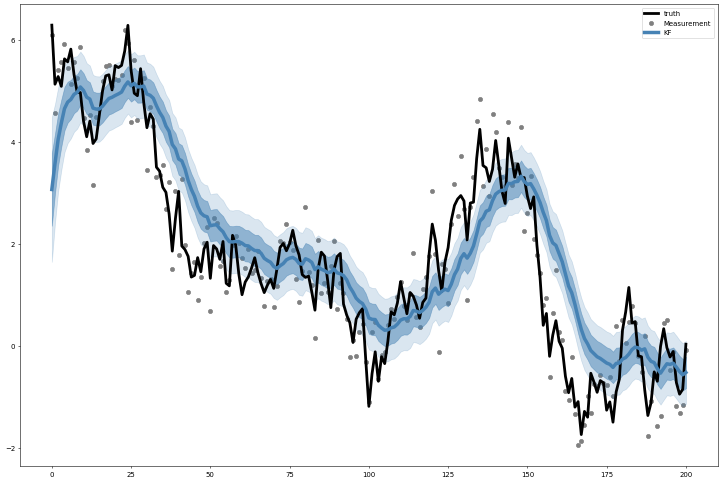

In [10]:
kf = MinimalKalmanFilter()

kf_mean, kf_variance = concatenate_mean_and_variance(run_kf(kf, X, y))

plot_truth()
plot_measurements()
plot_spread(X, kf_mean, kf_variance, label="KF")
plt.legend()

This first version of the  KF is not really performing well and certainly doesn't match the GP predictions (yet),

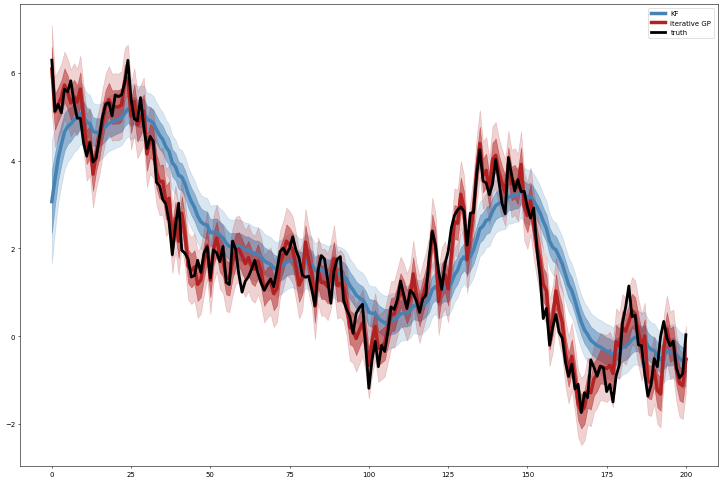

In [11]:
plot_spread(X, kf_mean, kf_variance, label="KF")
plot_spread(X, iterative_mean, iterative_variance, color="firebrick", label="Iterative GP")
plot_truth()
plt.legend()

The reason why these two are different is that we randomly picked the hyper parameters for the KF and the result is too smooth. Which leads us to the question, can we derive Kalman filter hyper parameters from a Gaussian process?

# Converting a Gaussian Process into a Kalman Filter

In this case we have known characteristics of the truth, let's use them to derive the hyper parameters for the Kalman filter. Remember, the truth was drawn from a GP. This means we can ask some questions directly related to the process model. Namely, if you're given the truth at time $t$, what would be the truth at time $t + \Delta$. To derive this we can use the covariance function, $k(|t - t'|)$, (which we assume is a radial covariance function, so it only depends on the time difference) to build a two variable GP prior,
$$
\begin{bmatrix} f_t \\ f_{t+\Delta} \end{bmatrix}
\sim
\mathcal{N}\left(
\begin{bmatrix} 0 \\ 0 \end{bmatrix},
\begin{bmatrix} k(0) & k(\Delta) \\ k(\Delta) & k(0) \end{bmatrix}
\right)
$$
Then we can use this to get the next time step given the current $f_{t + \Delta} | f_{t}$,
$$
f_{t + \Delta} | f_{t} \sim
\mathcal{N} \left(
\frac{k(\Delta)}{k(0)} f_{t},
k(0) - \frac{k(\Delta) k(\Delta)}{k(0)}
\right)
$$
With an exponential covariance function, $k(\Delta t) = \mbox{e}^{-|\Delta| / \ell}$, this gives us
$$
f_{t + \Delta} | f_{t} \sim
\mathcal{N} \left(
\mbox{e}^{-\Delta/ \ell}  f_{t},
\sigma^2 \left(1 - \mbox{e}^{-2\Delta / \ell} \right)
\right)
$$
This let's us read off the theoretical value for $\sigma_q$. If the state at time $t$ was perfectly know, the state at time $t+1$ would have a standard deviation of,
$$
\sigma_q = \sigma \sqrt{1 - \mbox{e}^{-2\Delta / \ell}}
$$
Similarly we can get the initial (prior) variance of the state which is simply,
$$
\begin{align}
P_0 &= k(0) \\
&= \sigma^2
\end{align}
$$
this lets us take the covariance function from a GP and derive the hyper parameters for a KF,

In [12]:
def kf_equivalent_params(cov_func):
    cov_0 = cov_func(0., 0.)[0, 0]
    cov_dt = cov_func(0., 1.)[0, 0]
    # YOUR CODE HERE
    #return {"process_noise": process_noise,
    #        "initial_variance": initial_variance}

TEST_KF_EQUILVALENT_PARAMS(kf_equivalent_params)

NotImplementedError: None was returned, you need to implement the missing parts (and return a dict)

Let's rerun the Kalman filter with these hyper parameters,

In [ ]:
def kf_equivalent(cov_func):
    params = kf_equivalent_params(cov_func)
    return MinimalKalmanFilter(meas_noise=MEAS_NOISE_SIGMA*MEAS_NOISE_SIGMA, **params)

kf = kf_equivalent(example_cov_func)

kf_mean, kf_variance = concatenate_mean_and_variance(run_kf(kf, X, y))

plot_truth()
plot_measurements()
plot_spread(X, kf_mean, kf_variance, label="KF")
plt.legend()

Much better! Now let's compare the result with a GP,

In [ ]:
plot_spread(X, kf_mean, kf_variance, label="KF")
plot_spread(X, iterative_mean, iterative_variance, color="firebrick", label="Iterative GP")
plt.legend()

Bingo! We built a Kalman Filter which reproduces a (real-time) GP solution. Though worth noting, we specifically picked this toy problem to make the derivation process easy, smoother Gaussian process priors will require more complicated Kalman filters (we'll get to that later)

# Caveats
We found a Kalman filter formulation which _very nearly_ reproduces the results that a real-time Gaussian process would but the equivalence is _not perfect_. Consider the edge case where you don't actually have any measurements. We can still make predictions which for a Gaussian process involves just using the prior,

In [ ]:
prior_mean = np.zeros(X.shape[0])
prior_variance = np.diag(example_cov_func(X, X))

plot_spread(X, prior_mean, prior_variance, color="firebrick", label="GP prior")
plot_truth()

To see how a Kalman filter behaves without measurements we can just run the process model without ever updating,

In [ ]:
def kf_prior(kf, X, y):
    for i in range(X.shape[0]):
        kf.process_model()
        x, P = kf.predict()
        yield x[0], P[0, 0]

kf = kf_equivalent(example_cov_func)

kf_mean, kf_variance = concatenate_mean_and_variance(kf_prior(kf, X, y))

plot_spread(X, prior_mean, prior_variance, color="firebrick", label="GP prior")
plot_spread(X, kf_mean, kf_variance, label="KF prior")
plot_truth()
plt.legend()

See the difference? The "prior" for a Kalman filter increases with time. We designed the Kalman filter with a process model of $\mbox{x}_{k+1} = \mbox{x}_{k} + \mathcal{N}(0, \sigma_q^2)$. It has some initial variance, the process model simply advances the state forward in time and adds process noise. So (with these hyper parameters) when we query the Kalman filter for some time far in the future the resulting uncertainty is going to tend towards infinity! Meanwhile, in this example, we picked a Gaussian process with a stationary prior. The prior variance at time $t$ will be the same as $t + \Delta$, even for very large $\Delta$.

There's another related phenomena which leads to a difference between these two models. Let's see what happens during a simulated measurement outage. We can start with a continuous stream of measurements, but after time 50 we'll stop updating the filter,

In [ ]:
OUTAGE_TIME = 50
def kf_simulated_outage(kf, X, y):
    for i in range(X.shape[0]):
        kf.process_model()
        if i <= OUTAGE_TIME:
            kf.update(X[i,:], y[i])
        x, P = kf.predict()
        yield x[0], P[0, 0]
        
kf = kf_equivalent(example_cov_func)

kf_outage_mean, kf_outage_variance = concatenate_mean_and_variance(kf_simulated_outage(kf, X, y))

plot_spread(X, kf_outage_mean, kf_outage_variance, label="KF outage")
plot_truth()
plt.legend()

Now here's the same thing with a GP,

In [ ]:
def gp_simulated_outage(X, y):
    for i in range(X.shape[0]):
        # at each time t_i, we can use all the observations up to the current time.
        # to predict the i^th state.
        k = min(i, OUTAGE_TIME)
        m, S = example_fit_and_predict(example_cov_func, X[:k+1], y[:k+1],
                                       X[i, :], meas_noise=MEAS_NOISE_SIGMA)
        yield m[0], S[0, 0]

gp_outage_mean, gp_outage_variance = concatenate_mean_and_variance(gp_simulated_outage(X, y))

plot_spread(X, gp_outage_mean, gp_outage_variance, color="firebrick", label="GP outage")

In [ ]:
plot_spread(X, gp_outage_mean, gp_outage_variance, color="firebrick", label="GP outage")
plot_spread(X, kf_outage_mean, kf_outage_variance, label="KF outage")
plt.legend()

See the difference? The mean estimates during the outage slowly diverge. As noted above, the prior for a stationary Gaussian process will be the same everywhere. So a GP queried a long way from any other measurements will return the prior ... which is mean zero.

Note that while this particular Kalman filter will continue to return the same state during an outage, but that isn't strictly neccesary. If we're repeatedly applying the process model,
$$
x_{k + 1} = F x_k \\
\vdots \\
x_{k + n} = F^n x_k
$$
So if we set $F < 1$, then the KF state will also tend back towards zero. More generally any eigen directions of $F$ for which the eigen value is $1$ will stay fixed during an outage. Any below $1$ will also converge to zero (and hopefully none are above $1$ or the filter will be unstable).

So, if we truly want our Kalman filter approximation to a GP to align more closesly we can modify the process model. You may have noticed we already set the model up with a configruable process model. We can use the same derivation as before to get,
$$
F = \begin{bmatrix} \frac{k(\Delta t)}{k(0)} \end{bmatrix}
$$
Let's (re)implement the `kf_equivalent_params` method but include $F$, the process model,

In [ ]:
def kf_equivalent_params(cov_func):
    cov_0 = cov_func(0., 0.)[0, 0]
    cov_dt = cov_func(0., 1.)[0, 0]
    # YOUR CODE HERE
    #return {"process_noise": process_noise,
    #        "initial_variance": initial_variance,
    #        "process_model": process_model}

print(kf_equivalent_params(example_cov_func))
TEST_KF_EQUILVALENT_PARAMS(kf_equivalent_params)

In [ ]:
kf = kf_equivalent(example_cov_func)

kf_outage_mean, kf_outage_variance = concatenate_mean_and_variance(kf_simulated_outage(kf, X, y))

plot_spread(X, gp_outage_mean, gp_outage_variance, color="firebrick", label="GP outage")
plot_spread(X, kf_outage_mean, kf_outage_variance, label="KF outage")
plt.legend()

Now the mean predictions during an outage match (but the KF's variance still tends towards infinity).

# Gaussian Process from Kalman Filter?
We just showed that (for a very specific) covariance function we can find a Kalman Filter which approximately reproduces real-time GP performance. Can we do the opposite? Lets consider a generic Kalman Filter with a process model,
$$
\mathbf{x}_{k+1|k} = F \mathbf{x}_{k|k} + \mathcal{N}\left(0, Q\right)
$$
and measurement model,
$$
\mathbf{y}_{k} = H \mathbf{x}_{k} + \mathcal{N}\left(0, R\right)
$$
We can use the process model to compute the prior between two times,
$$
\begin{align}
\begin{bmatrix}
\mathbf{x}_{k}\\
\mathbf{x}_{k+1}
\end{bmatrix} &= 
  \begin{bmatrix} I \\ F \end{bmatrix} \mathcal{N}\left(0, P_0\right) + \mathcal{N}\left(0, \begin{bmatrix}
     0 & 0 \\
     0 & Q
   \end{bmatrix}\right) \\
&\sim
\mathcal{N}\left(
0, \begin{bmatrix}
     P_0 & P_0 F^T \\
     F P_0 & F P_0 F^T + Q
   \end{bmatrix}
\right)
\end{align}
$$
For now let's stick with the 1D toy problem we have here, so we can assume all these variables are scalars, specifically $P_0 = \sigma^2$, $F = \alpha$ and $Q = \gamma^2$. 


Using those simplifications and repeating again,
$$
\begin{align}
\begin{bmatrix}
\mathbf{x}_{k}\\
\mathbf{x}_{k+1}\\
\mathbf{x}_{k+2}
\end{bmatrix} &=
\begin{bmatrix} 1 & 0\\ 0 & 1 \\ 0 & \alpha \end{bmatrix}
\begin{bmatrix}
\mathbf{x}_{k}\\
\mathbf{x}_{k+1}
\end{bmatrix} + \mathcal{N}\left(0, \begin{bmatrix}
     0 & 0 & 0\\
     0 & 0 & 0\\
     0 & 0 & Q
   \end{bmatrix}\right) \\
&\sim
\mathcal{N}\left(
0, \begin{bmatrix}
     \sigma^2 & \alpha \sigma^2 & \alpha^2 \sigma^2 \\
     \alpha \sigma^2 & \alpha^2 \sigma^2 + \gamma^2 & \alpha (\alpha^2 \sigma^2 + \gamma^2) \\
     \alpha^2 \sigma^2 & \alpha (\alpha^2 \sigma^2 + \gamma^2)  & \alpha^4 \sigma^2 + \alpha^2 \gamma^2 + \gamma^2
   \end{bmatrix}
\right)
\end{align}
$$
and we begin to see a pattern. Along the diagonal we have the marginal prior,
$$
\begin{align}
\mbox{cov}(t+\Delta, t+\Delta) &= \alpha^{2\Delta } \sigma^2 + \gamma^2 \sum_{i=0}^{\Delta-1} \alpha^i \\
&= \alpha^{2\Delta} \sigma^2 + \left(\frac{1 - \alpha^{2\Delta}}{1 - \alpha^2}\right) \gamma^2
\end{align}
$$

along the off diagonals we'll have,
$$
\begin{align}
\mbox{cov}(t+\Delta, t+\Delta+\delta) &= \alpha^\delta \mbox{cov}(t+\Delta, t+\Delta)
\end{align}
$$

The covariance function is NOT stationary, because we cannot express the covariance function simply as a functio of the temporal distance, $\mbox{cov}(t, t^\prime) = k(|t - t^\prime|)$. Instead, the covariance is a function of the time. Let's give it a try. Here we'll write a new covariance function which _should_ give us a GP which provides the same reults as a KF.

In [ ]:
def get_equivalent_cov_func(sigma, alpha, gamma):

    def cov_func(x_i, x_j):
        # resize the inputs
        x_i = np.expand_dims(reshape_inputs(x_i), 1)
        x_j = np.expand_dims(reshape_inputs(x_j), 0)
        output = np.zeros((x_i.shape[0], x_j.shape[1]))
        for i in range(output.shape[0]):
            for j in range(output.shape[1]):
                i_val = x_i[i, :].item()
                j_val = x_j[:, j, :].item()
                # offset = \Delta above
                offset = min(i_val, j_val)
                b = max(i_val, j_val)
                # d = \delta
                d = b - offset
                a2offset = np.power(alpha, 2*offset)
                frac = (1 - a2offset) / (1 - alpha * alpha)
                ad = np.power(alpha, d)
                marginal = a2offset * np.square(sigma) + frac * np.square(gamma)
                output[i, j] = np.power(alpha, d) * marginal
        return output
    return cov_func

Just to be sure we aren't cheating, we'll change the hyper parameters for the KF a little bit,

In [ ]:
initial_variance = 100.
process_noise = 0.5
process_model = 0.9999

kf = MinimalKalmanFilter(initial_variance=initial_variance,
                               process_noise=process_noise,
                               meas_noise=MEAS_NOISE_SIGMA*MEAS_NOISE_SIGMA,
                               process_model=process_model)

kf_mean, kf_variance = concatenate_mean_and_variance(run_kf(kf, X, y))

cov_func = get_equivalent_cov_func(sigma=np.sqrt(initial_variance),
                                   alpha=process_model,
                                   gamma=np.sqrt(process_noise))
gp_equivalent_mean, gp_equivalent_variance = concatenate_mean_and_variance(real_time_gp(cov_func, X, y))

plot_spread(X, kf_mean, kf_variance, color="steelblue", label="KF")
plot_spread(X, gp_equivalent_mean, gp_equivalent_variance, color="firebrick", label="GP Equivalent")
plt.legend()

Not the most efficent implementation, but the results match. If we want to implement a Kalman smoother (not a filter), we can just re-use that covariance function with a batch GP,

In [ ]:
smoother_mean, smoother_covariance = example_fit_and_predict(cov_func, X, y,
                                                                     X_grid, meas_noise=MEAS_NOISE_SIGMA)
plot_spread(X, kf_mean, kf_variance, color="steelblue", label="KF")
plot_spread(X, smoother_mean, np.diag(smoother_covariance), color="firebrick", label="KF Smoother Equivalent")
plt.legend()

# Equivalence with Smooth Processes
In the previous example we used a random walk which is known to satisfy the markov assumption required by a Kalman filter, namely: the next state is only a function of the previous state. This made the conversion from GP to KF easy, so what would we need to do differently if the process we're modelling is smooth?

We can setup a very similar experiment, but this time we'll draw the truth from a squared exponential covariance function,

In [ ]:
np.random.seed(2012)

def smooth_cov(x_i, x_j):
    return example_squared_exponential(x_i, x_j, sigma=5., ell=1000)

cov_matrix = smooth_cov(X_grid, X_grid)
truth = np.random.multivariate_normal(np.zeros(X_grid.shape[0]), cov_matrix)

y = truth + MEAS_NOISE_SIGMA * np.random.normal(size=X.size)

plot_truth()
plot_measurements()
plt.legend()

Again we can run a real time GP on the simulated data,

In [ ]:
smooth_mean, smooth_variance = concatenate_mean_and_variance(real_time_gp(smooth_cov, X, y))

plot_truth()
plot_measurements()

plot_spread(X, smooth_mean, smooth_variance, color="firebrick", label="GP")

plt.legend()

And can use the Kalman filter equivalence formula from above

In [ ]:
kf = kf_equivalent(smooth_cov)

kf_mean, kf_variance = concatenate_mean_and_variance(run_kf(kf, X, y))

plot_truth()
plot_measurements()
plot_spread(X, kf_mean, kf_variance, label="KF")
plt.legend()

In [ ]:
plot_spread(X, smooth_mean, smooth_variance, color="firebrick", label="GP")
plot_spread(X, kf_mean, kf_variance, label="KF")
plt.legend()

But wait! The two are no longer the same! The difference stems from the fact that the GP has access to the full history of measurements which all collaborate to make a prediction of the current state, while the KF keeps track of only the most recent estimate of the state, so it can't enforce the same smoothness assumptions. We can improve this by adding a velocity term to the KF so we have,
$$
x_t = \begin{bmatrix} f(t) \\ \frac{\partial f}{\partial t}(t) \end{bmatrix}
$$
with a process model that looks something like
$$
F = \begin{bmatrix}
1 & \Delta t \\
0 & 1
\end{bmatrix}
$$

We can still use the covariance function to derive the Kalman filter parameters, though it gets a little more complex. We can use a finite element inspired approach to first describe the state in the neighborhood of $x_t$. We'll use central differencing, so we can evaluate the covariance function at three points,
$$
\xi_t = [x_t - \epsilon, x_t, x_t + \epsilon] \\
\Sigma = k(\xi_t, \xi_t)
$$
This gives us,
$$
\begin{bmatrix}
f(x_t - \epsilon) \\ f(x_t) \\ f(x_t + \epsilon)
\end{bmatrix}
\sim
\mathcal{N}\left(
0, \Sigma
\right)
$$
and then we can take the central differencing operator which says that,
$$
\begin{align}
\frac{\partial f}{\partial t}(t) \approx \frac{ f(x_t + \epsilon) - f(x_t - \epsilon)}{2 \epsilon} \\
\frac{\partial f}{\partial t}(t) \approx \begin{bmatrix} -0.5 & 0 & 0.5 \end{bmatrix}
\begin{bmatrix}
f(x_t - \epsilon) \\ f(x_t) \\ f(x_t + \epsilon)
\end{bmatrix}
\end{align}
$$
Similarly we can extract only the central term with a vector, $\begin{bmatrix} 0 & 1 & 0 \end{bmatrix}$, so we can write our Kalman filter state as a function of the finite element approximation,
$$
\begin{align}
\begin{bmatrix} f(t) \\ \frac{\partial f}{\partial t}(t) \end{bmatrix} &\approx
\begin{bmatrix}
0 & 1 & 0 \\
-0.5 & 0 & 0.5
\end{bmatrix}
\begin{bmatrix}
f(x_t - \epsilon) \\ f(x_t) \\ f(x_t + \epsilon)
\end{bmatrix} \\
&\approx C \begin{bmatrix}
f(x_t - \epsilon) \\ f(x_t) \\ f(x_t + \epsilon)
\end{bmatrix}
\end{align}
$$
Which then lets us evaluate the initial state,
$$
\mathbf{x} \sim \mathcal{N}\left(
0, C \Sigma C^T
\right)
$$
Then, like before, we can stack the current state and the next state to help derive the process model,
$$
\begin{align}
\begin{bmatrix}
  x_t \\ x_{t+\Delta t}
\end{bmatrix} &=
\begin{bmatrix}
C & 0 \\
0 & C
\end{bmatrix}
\begin{bmatrix}
f(x_t - \epsilon) \\ f(x_t) \\ f(x_t + \epsilon) \\
f(x_t + \Delta t - \epsilon) \\ f(x_t + \Delta t) \\ f(x_t + \Delta t + \epsilon)
\end{bmatrix}\\
&\sim
\begin{bmatrix}
C & 0 \\
0 & C
\end{bmatrix} \mathcal{N}
  \left(0,
    \begin{bmatrix} \Sigma & \Sigma_{\Delta t} \\
                    \Sigma_{\Delta t} & \Sigma
    \end{bmatrix}
  \right)\\
& \sim
\mathcal{N}
  \left(0,
    \begin{bmatrix} C \Sigma C^T & C \Sigma_{\Delta t} C^T \\
                    C \Sigma_{\Delta t} C^T & C \Sigma C^T
    \end{bmatrix}
  \right) \\
& \sim
\mathcal{N}
  \left(0,
    \begin{bmatrix} K_0 & K_{\Delta} \\
                    K_{\Delta}^T & K_0
    \end{bmatrix}
  \right)
\end{align}
$$

And again, we can use this get $x_{t+\Delta t}$ given $x_t$,
$$
x_{t+\Delta t} \sim \mathcal{N}\left(
K_\Delta K_0^{-1} x_t, K_0 - K_\Delta K_0^{-1} K_\Delta^T
\right)
$$
Which gives us,
$$
F = K_\Delta K_0^{-1}
$$
and 
$$
Q = K_0 - K_\Delta K_0^{-1} K_\Delta^T
$$
Basically the same idea as before, but now we're dealing with matrices, not scalars. Let's actually compute those for this example,

In [ ]:
cov_func = smooth_cov

def derive_kalman_filter_matrices(cov_func, order):
    epsilon = 1e-3

    offsets = np.linspace(-order, order, 2*order + 1)
    x_perturbed = epsilon * offsets
    x_shifted = x_perturbed + 1

    C = np.array([
        np.power(epsilon, -i) * scipy.misc.central_diff_weights(x_perturbed.size, i)
        for i in range(order + 1)
    ])

    S = cov_func(x_perturbed, x_perturbed)
    S_delta = cov_func(x_perturbed, x_shifted).T

    K_0 = C @ S @ C.T
    K_delta = C @ S_delta @ C.T

    P_init = K_0
    F = np.linalg.solve(K_0, K_delta.T).T
    Q = K_0 - K_delta @ np.linalg.solve(K_0, K_delta.T)
    Q = Q + 1e-8 * np.eye(Q.shape[0])

    return P_init, F, Q

Then we need a new KF implementation which keeps track of two states, the truth and it's derivative,

In [ ]:
class SmoothKalmanFilter(object):
    
    def __init__(self, order, P_init, F, Q, meas_noise=1.0):
        self.x = np.zeros((order + 1, 1))
        self.P = P_init
        self.F = F
        self.Q = Q
        self.H = np.zeros((1, order + 1))
        self.H[0, 0] = 1
        self.R = np.array([[meas_noise]])
    
    def process_model(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, X, y):
        y = np.atleast_1d(y)
        S = self.H @ self.P @ self.H.T + self.R
        K = np.linalg.solve(S, self.H @ self.P).T
        y_hat = self.H @ self.x
        self.x = self.x + K @ (y - y_hat)
        self.P = self.P  - K @ self.H @ self.P
        
    def predict(self):
        return self.x[:1], self.P[[0, 0]]
    
def derive_kalman_filter(smooth_cov, order):
    P_init, F, Q = derive_kalman_filter_matrices(smooth_cov, order=order)
    return SmoothKalmanFilter(order, P_init, F, Q, meas_noise=MEAS_NOISE_SIGMA*MEAS_NOISE_SIGMA)

And then we can compare the two, which _should_ mostly agree.

In [ ]:
kf = derive_kalman_filter(smooth_cov, order=1)
kf_mean, kf_variance = concatenate_mean_and_variance(run_kf(kf, X, y))

batch_mean, batch_variance = example_fit_and_predict(smooth_cov, X, y,
                                                     X, meas_noise=MEAS_NOISE_SIGMA)

plot_spread(X, smooth_mean, smooth_variance, color="firebrick", label="GP")
plot_spread(X, kf_mean, kf_variance, label="KF")
plot_truth()
plt.legend()

In this case it only seems to have taken one derivative in the kalman filter to replicate the squared exponential covariance, but in general it may take more like 4 or 5 (and in theory it would require infinite)

# Conclusion
We've shown that for a few toy problems we can convert a GP into a KF and vice versa. This just touches the surface on equivalencies between various covariance functions, Kalman filter equivalents and ways to frame them both as Stochastic PDEs. For more I'd strongly suggest this thesis:

[Stochastic Differential Equation Methods for Spatio-Temporal Gaussian Process Regression - Arno Solin
](https://aaltodoc.aalto.fi/server/api/core/bitstreams/aaf7725c-7955-4d21-8d31-e27fdd23c503/content)

As mentioned, the "real time" GP is not actually feasible in real time, it would quickly grow too large to manage. However, using the sparse Gaussian process approch from previous tutorials we can end up with a relatively efficient approximation. Perhaps a topic for a future tutorial.

# Appendix: Random Insight

One interesting thing that came up when writing this tutorial was despite having picked an extremely smooth covariance function the real time predictions using the GP are not particularly smooth. To see why this happens try playing around with this interactive plot which shows the "real time" GP predictions up to a certain time and the forward looking predictions using the GP fit up to that time. You can see the forward looking predictions are always very smooth, but the immediate prediction is influenced by recent observations which cause the predictions to wander around a little more than you may expect.

In [ ]:
@interact
def interactive_plot_fit_and_predict(i=(0, X.shape[0])):
    plot_fit_and_predict(i, smooth_cov, X, y)
